# DAPI prediction based on stardist

In [96]:
# from __future__ import print_function, unicode_literals, absolute_import, division

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pathlib import Path
from glob import glob
from datetime import datetime

import pandas as pd
import numpy as np
np.random.seed(6)

from tifffile import imread
from tifffile import imwrite
from csbdeep.utils import normalize

import matplotlib.pyplot as plt
plt.rcParams["image.interpolation"] = 'nearest'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from stardist import random_label_cmap
lbl_cmap = random_label_cmap()

## model loading

In [99]:
CHANNELS = ['cy5', 'TxRed', 'cy3', 'FAM']
BASE_DIR = Path('E:/TMC/PRISM_pipeline/dataset/processed')
RUN_ID = '20230227_test'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
os.makedirs(seg_dir, exist_ok=True)

# choose and load models
from stardist.models import StarDist3D
model = StarDist3D(None, name="stardist", basedir="./models")

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.52949, nms_thresh=0.3.


## prediction

dataset: 0704_CTX_DAPI, 0704_HT_DAPI, 0706_TH_DAPI, 0710_HP_DAPI
result_path: .\dataset\20240101_PRIDM3D_relabel_of_mousebrain_with_big_predict\results
current_work: 0704_CTX_DAPI
effective: block_size=(92, 664, 664), min_overlap=(32, 96, 96), context=(12, 32, 32)
Z: context of 12 is small, recommended to use at least 26
Y: context of 32 is small, recommended to use at least 46
X: context of 32 is small, recommended to use at least 46


0704_CTX_DAPI: 100%|██████████| 121/121 [28:02<00:00, 13.90s/it]


0704_CTX_DAPI: 8555 nucleus.
**************************************************
current_work: 0704_HT_DAPI
effective: block_size=(92, 664, 664), min_overlap=(32, 96, 96), context=(12, 32, 32)
Z: context of 12 is small, recommended to use at least 26
Y: context of 32 is small, recommended to use at least 46
X: context of 32 is small, recommended to use at least 46


0704_HT_DAPI: 100%|██████████| 120/120 [31:07<00:00, 15.57s/it]


0704_HT_DAPI: 14093 nucleus.
**************************************************
current_work: 0706_TH_DAPI
effective: block_size=(88, 680, 680), min_overlap=(32, 96, 96), context=(12, 32, 32)
Z: context of 12 is small, recommended to use at least 26
Y: context of 32 is small, recommended to use at least 46
X: context of 32 is small, recommended to use at least 46


0706_TH_DAPI: 100%|██████████| 114/114 [22:12<00:00, 11.69s/it]


0706_TH_DAPI: 8706 nucleus.
**************************************************
current_work: 0710_HP_DAPI
effective: block_size=(84, 696, 696), min_overlap=(32, 96, 96), context=(12, 32, 32)
Z: context of 12 is small, recommended to use at least 26
Y: context of 32 is small, recommended to use at least 46
X: context of 32 is small, recommended to use at least 46


0710_HP_DAPI: 100%|██████████| 108/108 [1:21:13<00:00, 45.12s/it]


0710_HP_DAPI: 37845 nucleus.
**************************************************


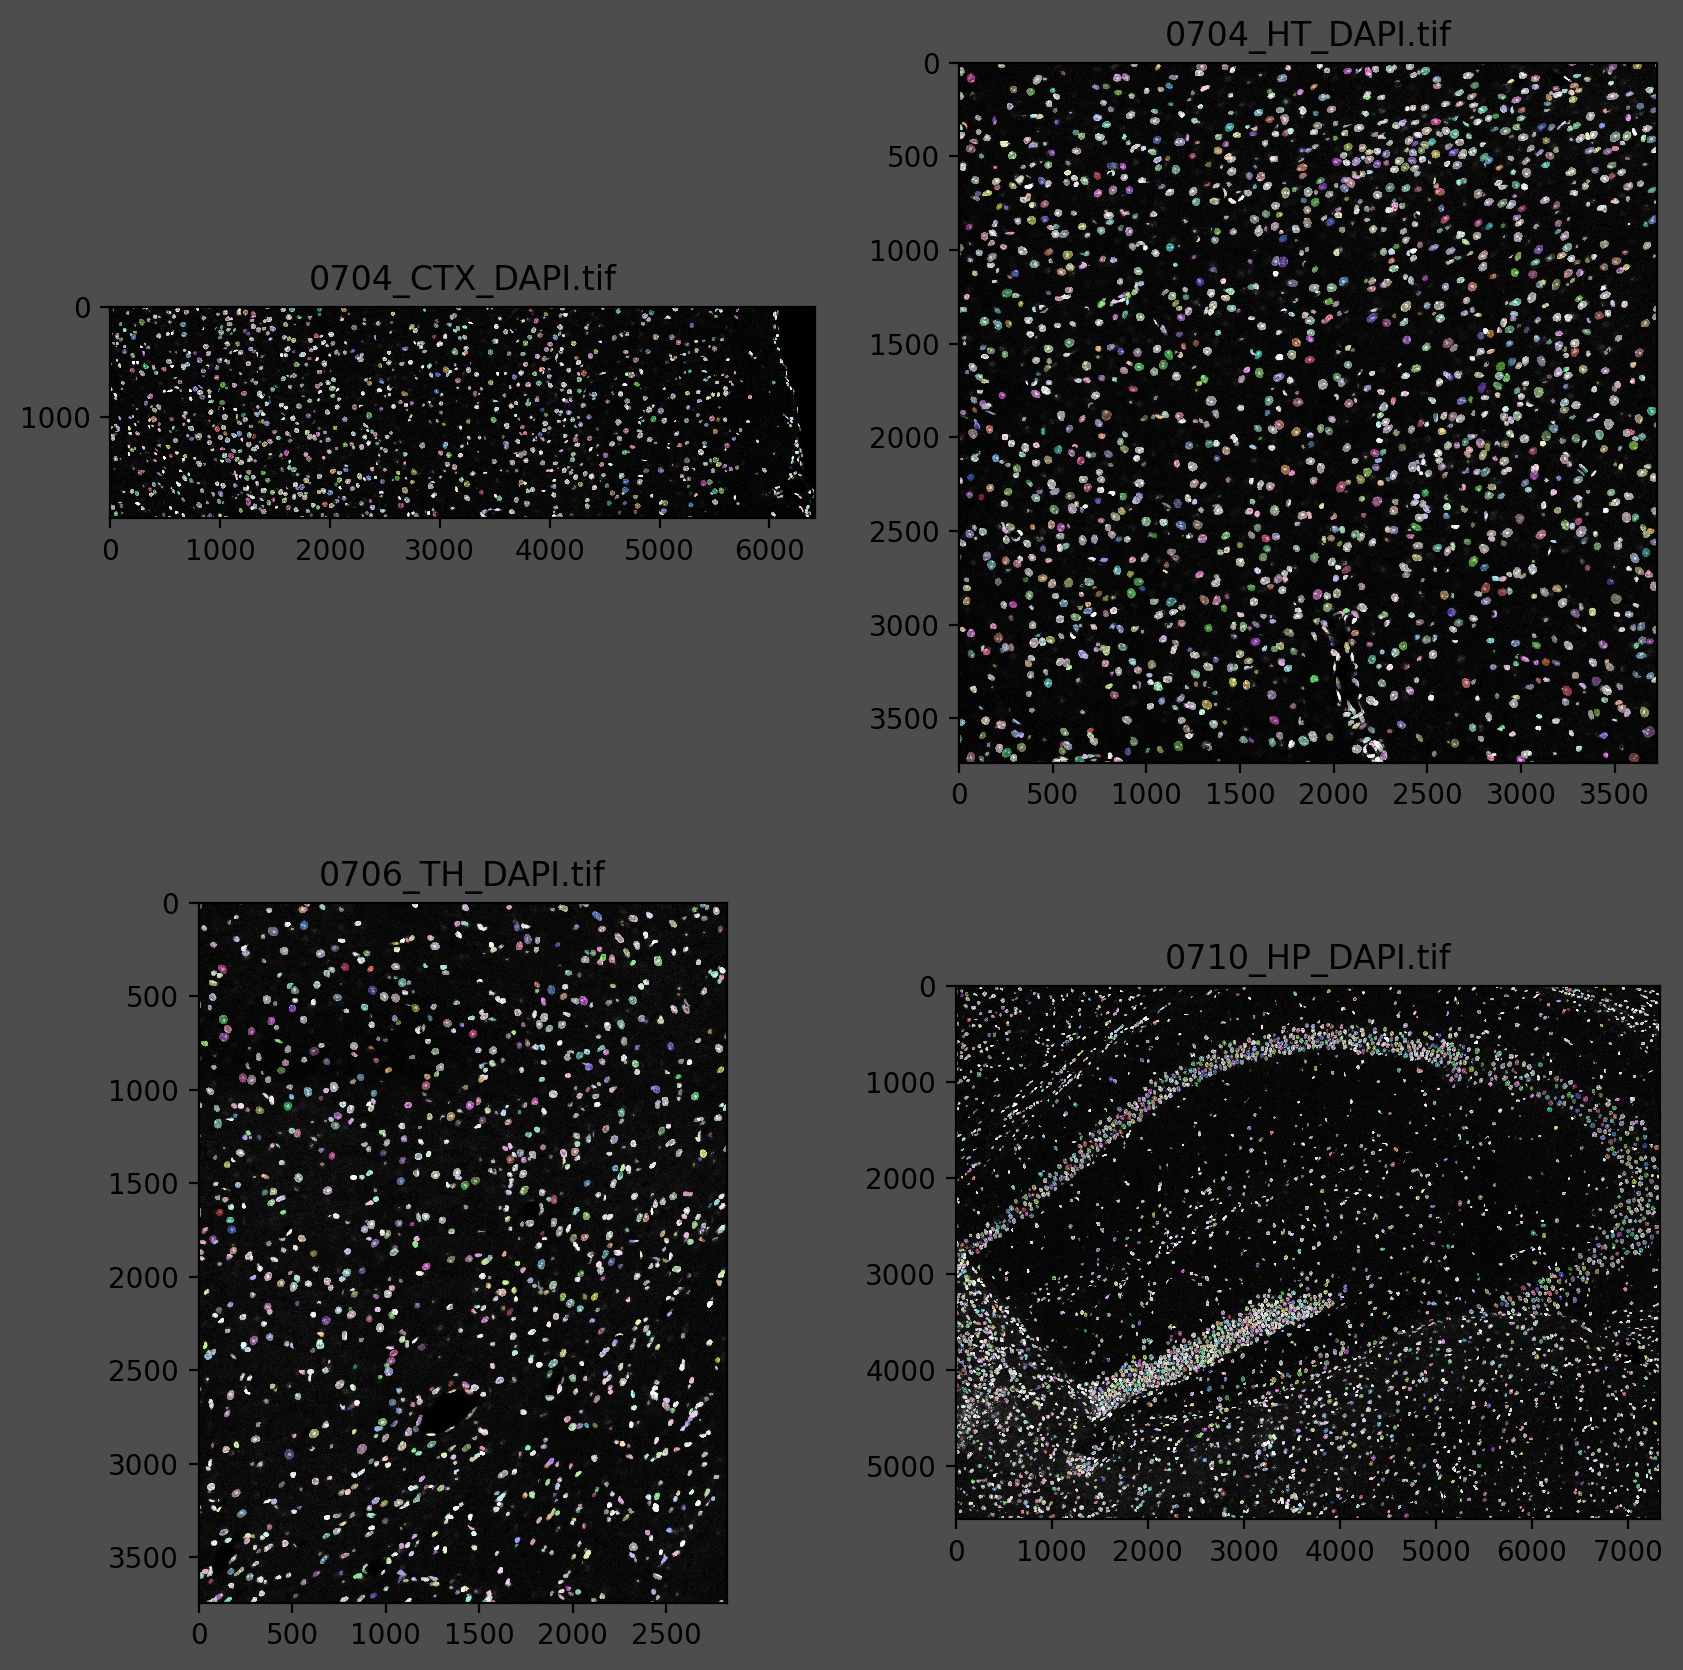

In [110]:
# Get the current date and time
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print(formatted_time)


# image and result path
raw_images_path_each = sorted(glob(stc_dir/'*dapi.tif'))
images_to_process = ', '.join(os.path.split(raw_image_path)[-1].replace(".tif", "") for raw_image_path in raw_images_path_each)
print(f'dataset: {images_to_process}')
print("result_path:", seg_dir)
print('*' * 50)


# visualization
rows = int(np.sqrt(len(raw_images_path_each)))
cols = -(-len(raw_images_path_each) // rows)
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(5 * cols, 5 * rows), facecolor=(0.3,0.3,0.3))
ax = ax.flat if isinstance(ax, np.ndarray) else [ax]

# batch process
dtype = np.uint16
for _, (tmp_ax, raw_image_path) in enumerate(zip(ax, raw_images_path_each)):
    # load image and preprocess
    raw_image = imread(raw_image_path)
    n_channel = 1 if raw_image.ndim == 3 else raw_image.shape[-1]
    axis_norm = (0, 1, 2)  # normalize channels independently
    if n_channel > 1:
        print("Normalizing image channels %s." % ("jointly" if axis_norm is None or 2 in axis_norm else "independently"))
    raw_image = normalize(raw_image, 1, 99.8, axis=axis_norm)
        
    # prediction
    file_name = os.path.split(raw_image_path)[-1].replace(".tif", "")
    print(f"current_work: {file_name}")

    ## prediction by predict_instances_big
    max_size = 512 * 512 * 150
    block_size_x = int(raw_image.shape[0] * 3 / 4)
    block_size_y = int(np.sqrt(max_size / block_size_x))
    block_size_z = int(np.sqrt(max_size / block_size_x))
    block_size = [block_size_x, block_size_y, block_size_z]
    predict_image, poly = model.predict_instances_big(raw_image, axes='ZYX', 
                                                    block_size=block_size, min_overlap=[30, 90, 90], 
                                                    context=[20, 40, 40],
                                                    labels_out_dtype=np.uint16, show_progress=True, predict_kwargs={'verbose':0},
                                                    )
    centroids_stardist = poly['points']

    ## save prediction file
    predict_image_path = seg_dir / f'{file_name}_predict.tif'
    imwrite(predict_image_path, predict_image)

    tmp_ax.imshow(raw_image[raw_image.shape[0] // 2], cmap="gray")
    tmp_ax.imshow(predict_image[predict_image.shape[0] // 2], cmap=lbl_cmap, alpha=0.5)
    tmp_ax.set_title(os.path.split(raw_image_path)[-1])
    

    ## save centroid of stardist and gray scale as csv and save image
    predict_centroid_path =seg_dir / f'{file_name}_predict_centroid_by_stardist.csv'
    centroids_stardist = pd.DataFrame(centroids_stardist, columns=['z_in_pix','x_in_pix','y_in_pix'])
    centroids_stardist.to_csv(predict_centroid_path)

    centroid_image = np.zeros_like(predict_image, dtype=dtype)
    for centroid in centroids_stardist[['z_in_pix','x_in_pix','y_in_pix']].values:
        z, x, y = [int(_) for _ in centroid]
        centroid_image[z, x, y] = np.iinfo(dtype).max

    centroid_image_path = seg_dir / f'{file_name}_predict_centroid_by_stardist.tif'
    imwrite(centroid_image_path, centroid_image)
    print('*' * 50)

# Get the current date and time
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print(formatted_time)